In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from models import *
from data_split import *

### **Autoencoders**

## **Exploratory Data Analysis**

In [2]:
data = pickle.load(open(r'../Data/deltaQ_cycles.pkl', 'rb'))
data2 = pickle.load(open(r'../Data/temp_features.pkl', 'rb'))

In [3]:
y = np.zeros(124)

x = np.zeros((124, 48*2))

for i, cell in enumerate(data.keys()):
    x[i, :48] = data[cell]["DeltaQ_logVars"][1:]
    # x[i, :, 1] = np.log10(-data[cell]["DeltaQ_mins"][9:])
    # x[i, 48:2*48] = data[cell]["DeltaQ_means"][1:]
    # x[i, 2*48:3*48] = data2[cell]["DeltaT_var"][1:]
    x[i, 48:2*48] = data2[cell]["Delta_Tmax"][1:]
    y[i] = np.log10(data[cell]["cycle_life"])

# convert to tensors and concatenate features and labels
x = torch.Tensor(x)
y = torch.Tensor(y)

## **AutoEncoder: Dimensionality Reduction**

### **Train Test Split**


Stage 1:

Epoch 300/3000, loss: 17291.41
Epoch 600/3000, loss: 2640.29
Epoch 900/3000, loss: 2105.69
Epoch 1200/3000, loss: 1631.00
Epoch 1500/3000, loss: 1230.25
Epoch 1800/3000, loss: 934.39
Epoch 2100/3000, loss: 723.52
Epoch 2400/3000, loss: 598.53
Epoch 2700/3000, loss: 501.31
Epoch 3000/3000, loss: 418.47
train 	 63.674057
test 	 124.17289
sec 	 294.1399


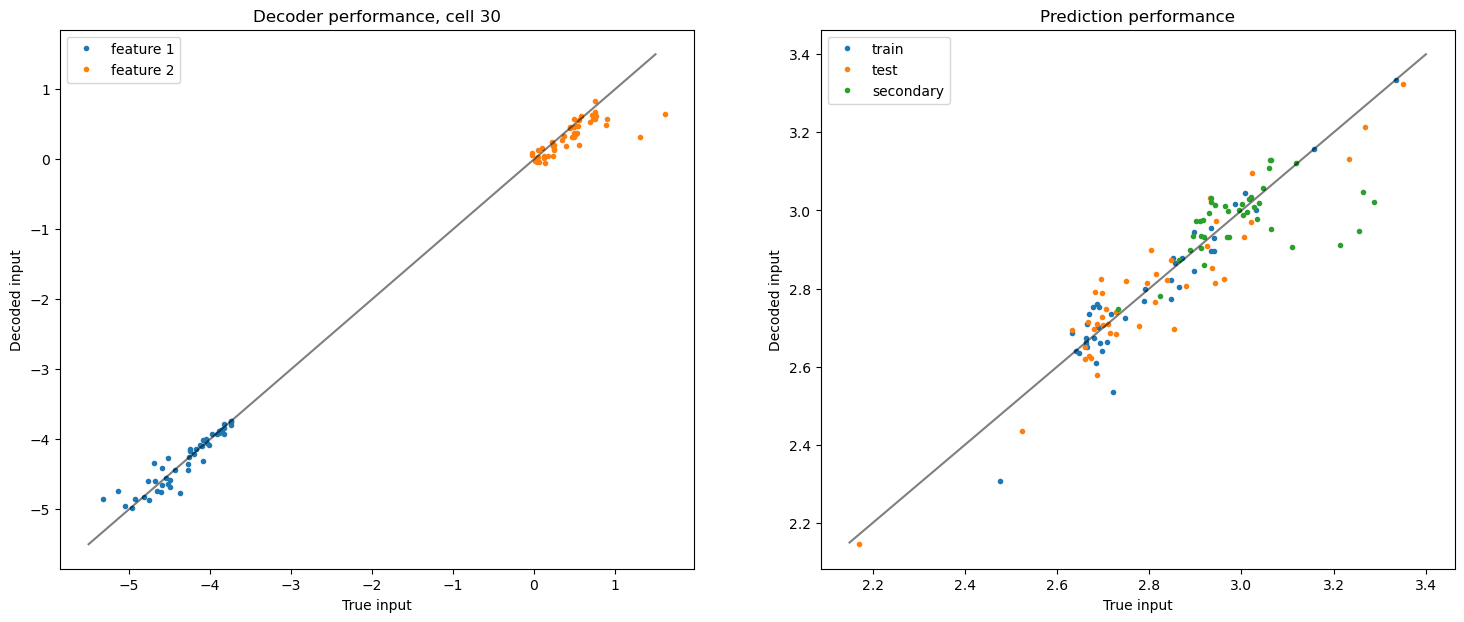


Stage 2:

Epoch 100/1000, loss: 1.64
Epoch 200/1000, loss: 1.60
Epoch 300/1000, loss: 1.55
Epoch 400/1000, loss: 1.51
Epoch 500/1000, loss: 1.47
Epoch 600/1000, loss: 1.43
Epoch 700/1000, loss: 1.40
Epoch 800/1000, loss: 1.36
Epoch 900/1000, loss: 1.33
Epoch 1000/1000, loss: 1.30
train 	 46.879597
test 	 135.21066
sec 	 298.63257


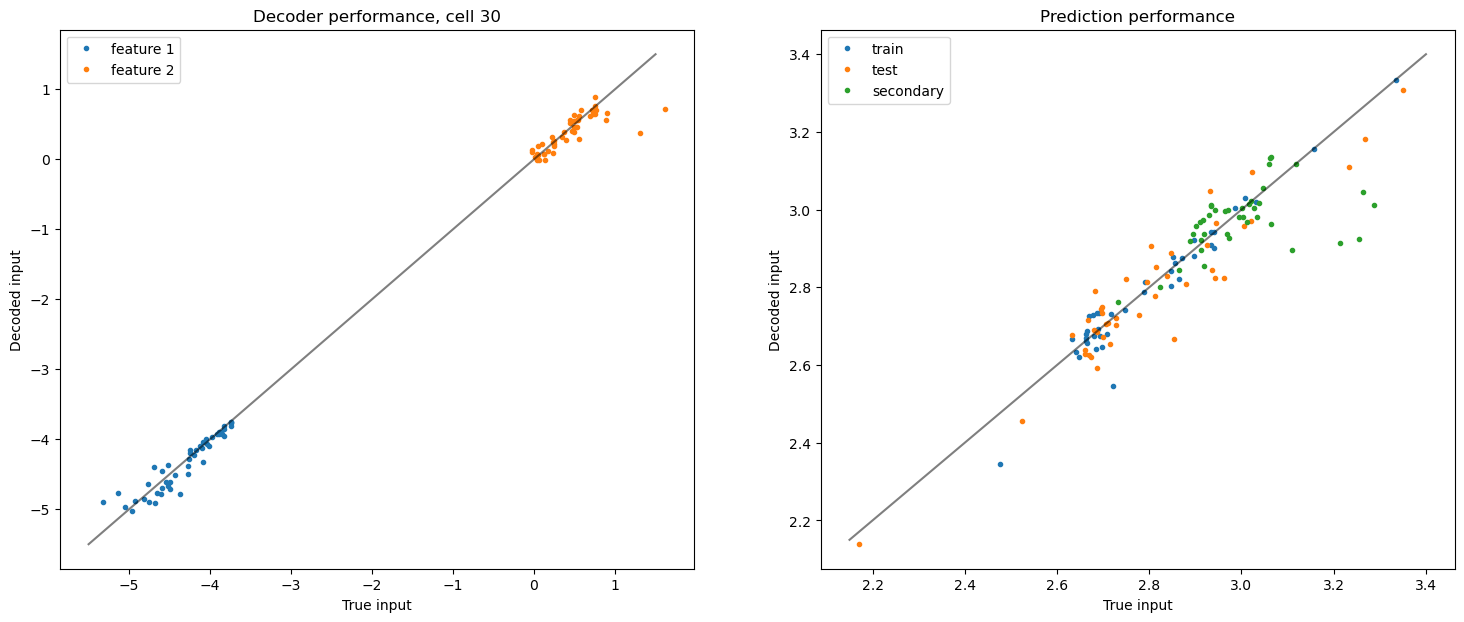

In [4]:
# del model

train_policy = {
    "num_stages": 2,
    "epochs": [3000, 1000],
    "learning_rates": [3e-5, 1e-5],
    "batch_sizes": [64, 64],
    "prediction_weights": [0.1, 0.0001],
    "decoding_weights": [10, 1],
    "en_weights": [1, 1]
}


model = AutoEncoder_ElasticNet(n_features=2, n_cycles=48)
# model.fit(train_dataset, decoding_weight=10)
# model.fit(train_dataset, prediction_weight=0.0001, decoding_weight=1, lr = 1e-5, epochs=1000)
model.fit(x, y, train_policy)